### Simple code to simulate mutation survival probability $u$

The below implements a simple finite difference iteration algorithm to simulate the equation

$$ \partial_t u= D u'' - v u' + a \Theta(x) u - \text{coff  } u^2 - \text{wind  } u'^2 $$

the iteration loop would likely run much faster in C, but even this code converges quite rapidly. One has to know, however, how to correctly set the key parameters. More on this below.

We'll first keep a finite value of coff, and later switch to coff=0.

In [468]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from tqdm import tqdm

def simulate_u(u_0, D, v, a, wind, coff, M, dt, dx, bc = [0, 1], debug=False, save_skip=1):
    # u_0: np.array of size M
    # debug: boundary conditions
    # save_skip: only save ever save_skip generations for memory reasons
    # Initialize the first time step
    u = u_0.copy()
    N = len(u_0)
    
    alpha = D * dt / dx**2
    print("α =", alpha)
    print("α * dx^2 =", alpha * dx**2)
    beta  = wind * dt / (4 * dx**2)
    gamma = v * dt / (4 * dx)
    omega = coff * dt
    
    a_vec = np.zeros(N-1)
    a_vec[N//4:] = a * dt
    a_mat = sparse.diags([a_vec], [0], format='csr')
    
    # A matrix, independent on u
    diag = np.ones(N-1) * (1 + 2*alpha)
    off_diag = -np.ones(N-2) * (alpha)
    A = sparse.diags([off_diag, diag, off_diag], [-1, 0, 1], format='csr')
    A -= a_mat
    v_mat = sparse.diags([np.ones(N-2) * gamma, np.ones(N-2) * (-gamma)], [1, -1], shape=(N-1, N-1), format='csr')
    A += v_mat 
                           
    """# C matrix, independent on u
    diag = np.ones(N-1) * (1 - 2*alpha)
    off_diag = - np.ones(N-2) * (alpha)
    C = sparse.diags([off_diag, diag, off_diag], [-1, 0, 1], shape=(N-1, N-1), format='csr')
    C += a_mat
    C -= v_mat"""
    
    V_BC = np.zeros(N-1)
          
    # Store each time step in a list
    u_list = [u.copy()]
    for k in tqdm(range(M - 1)):
        # Solve: 
        #    (A + B) * u^(n+1) = C * u^(n) + V_BC 
        # using sparse methods
        try:
            V_BC[-1] = (alpha - gamma + beta * (bc[1]-u[-2])) * bc[1]
            
            diff = u[2:-1] - u[:-3]
            diff = np.append(diff, bc[1] - u[-2])
            
            B = sparse.diags([-beta * diff, omega * u[:-1], beta * diff], [-1, 0, 1], shape=(N-1, N-1), format='csr')
            #B = create_B(u)
            # Solve
            rhs = u[:-1] + V_BC #C.dot(u[:-1]) + V_BC
            u_next = spsolve(A + B, rhs)
            
            # Apply boundary conditions
            #u_next = np.insert(u_next, 0, 0)#bc[0])  # Insert left boundary condition
            u_next = np.append(u_next, bc[1])     # Append right boundary condition
            #u_next = np.maximum(u_next, 0)
            if (k+1) % save_skip == 0: 
                u_list.append(u_next.copy())
            u = u_next
        except RuntimeWarning as e:
            # Print the time of the error
            print(f"RuntimeWarning occurred at time step {k} and time {k*dt}: {e}")
            break
    
    # Convert the list of arrays into a 2D NumPy array
    u_array = np.array(u_list)
    
    return u_array

In [549]:
def plot_time_slices(u, L, dt, N, M, v, D, v_over_vf, eps_over_delta, 
                     save_skip=1, fractions=[0.2, 0.4, 0.6, 0.8, 1.0], log_scale=False, 
                     xlim=None, ylim=None, psi_xlim=None, psi_ylim=None, gamma=False, psi=True):  
    x = np.linspace(0, L, N, dtype='f')
    colors = plt.cm.viridis(np.linspace(0, 1, len(fractions)))

    # Determine the number of subplots
    ncols = 2 if psi else 1
    fig, axes = plt.subplots(1, ncols, figsize=(10 * ncols, 8))

    for idx, fraction in enumerate(fractions):
        time_index = int(len(u) * fraction) if fraction not in [0, 1] else (0 if fraction == 0 else len(u) - 1)
        t_slice = time_index * dt * save_skip
        u_slice = u[time_index, 1:]
        X_slice = x[1:]
        u_slice = u_slice-u_slice[0]
        color = colors[idx]

        # Plot on the first subplot (original or Γ)
        axes[0].plot(X_slice, u_slice, label=f't={t_slice:.2g}', color=color)
        if log_scale:
            axes[0].set_yscale("log")
        axes[0].set_title('Original' if not gamma else 'Γ')
        
        if idx == 0: norm = 1e10#u_slice[int((L/dx)//4)] * np.exp(-(0.5 * v * L/4 / D))
        if psi:
            # Plot the transformed version on the second subplot
            n = 500
            factor = (L/4-X_slice) * v / (2 * D)
            psi_slice = np.exp(np.log(u_slice+1e-100) + factor)
            #psi_slice /= norm
            axes[1].plot(X_slice, psi_slice, label=f't={t_slice:.2g}', color=color)
            #axes[1].plot(X_slice, factor, color="pink")
            if log_scale:
                axes[1].set_yscale("log")
            axes[1].set_title('Transformed (ψ)')
    
    # Adjust settings for each axis
    axes[0].axvline(x=L/4, color='grey', linestyle='--')
    axes[0].axhline(y=a/coff, color='lightseagreen', linestyle='--')
    #axes[0].text(0, a/coff-0.05, 'a/δ', color='lightseagreen')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('u' if not gamma else 'Γ')
    axes[0].legend()

    if psi:
        axes[1].axvline(x=L/4, color='grey', linestyle='--')
        axes[1].set_xlabel('x')
        axes[1].yaxis.tick_right()
        axes[1].yaxis.set_label_position("right")
        axes[1].set_ylabel('ψ')
        if psi_xlim is not None: axes[1].set_xlim(psi_xlim)
        if psi_ylim is not None: axes[1].set_ylim(psi_ylim)
        axes[1].legend()

    if xlim is not None:
        axes[0].set_xlim(xlim)
        if not psi: axes[1].set_xlim(xlim)
    if ylim is not None:
        axes[0].set_ylim(ylim)

    # Adjust layout to make subplots flush vertically
    plt.subplots_adjust(wspace=0.05)
    
    plt.suptitle(f'Time Slices, vf = {v_over_vf:.3f}v, ε/δ = {eps_over_delta:.3f}')
    plt.show()

v = 0.6261309767133392
Natural length scale L_N = 10.0
L/L_N = 30.0
L_N/dx = 20.0
Max time T/T_N: 20.0


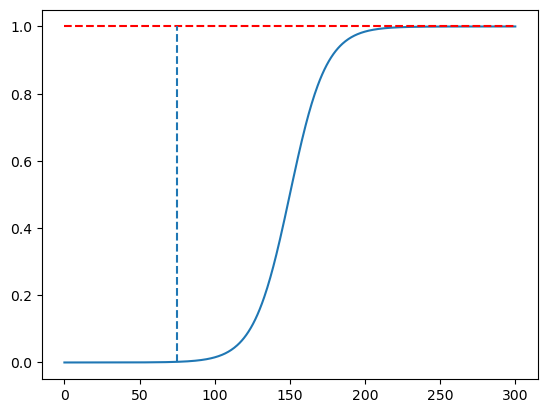

In [550]:
# Constants
D = 1  # Diffusion coefficient
a = 0.1  # growth rate 
coff = 0.1 #  strength of u^2 non-linearity 
wind = 1.0 #  strength of u'^2 non-linearity 
vf = 2 * (D*a)**0.5
v = 0.99 * vf # wind speed
print(f"v = {v}")

# Lattice
L_N = np.sqrt(D)/a
print("Natural length scale L_N =", L_N)
L = 300.0  # Length of the domain
dx = 0.5# Spatial step size
N = int(L / dx) + 1
print(f"L/L_N = {L/L_N}")
print(f"L_N/dx = {L_N/dx}")
M = 20000 # Number of time steps
dt = 0.01  # Time step size
print(f"Max time T/T_N: {M*dt/(1/a)}")

# Set and plot initial value
L_center = L / 2  # center point
width = L / 25  # controls the steepness of the sigmoid
N0 = a / coff  # asymptote for the sigmoid
# Set the initial condition using a sigmoid function
u_0 = N0 / (1 + np.exp(- (np.linspace(0, L, N) - L_center) / width))
u_0 *= a / coff / u_0[-1]
u_0[0] = 0
u_0[1] = 0
plt.plot(np.linspace(0, L, N), u_0)
plt.hlines(a/coff, 0, L, colors='r', linestyles='dashed')
plt.vlines(L/4, 0, a/coff, linestyles='dashed')

In [545]:
save_skip = 1# for memory
u = simulate_u(u_0, D, v, a, wind, coff, M, dt, dx, bc = [0, a/coff], save_skip=save_skip)

α = 0.04
α * dx^2 = 0.01


100%|██████████| 19999/19999 [00:11<00:00, 1801.78it/s]


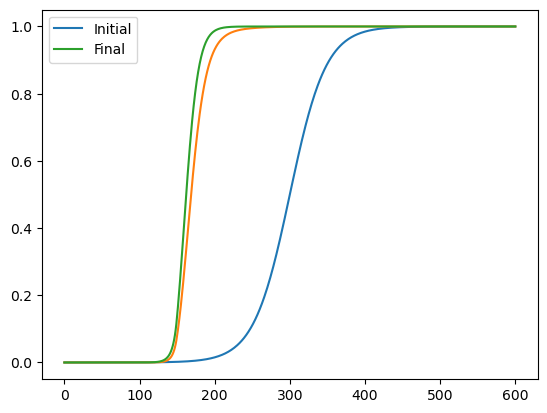

In [546]:
plt.plot(u[0], label="Initial")
plt.plot(u[len(u)//2])
plt.plot(u[-1], label="Final")
plt.legend()

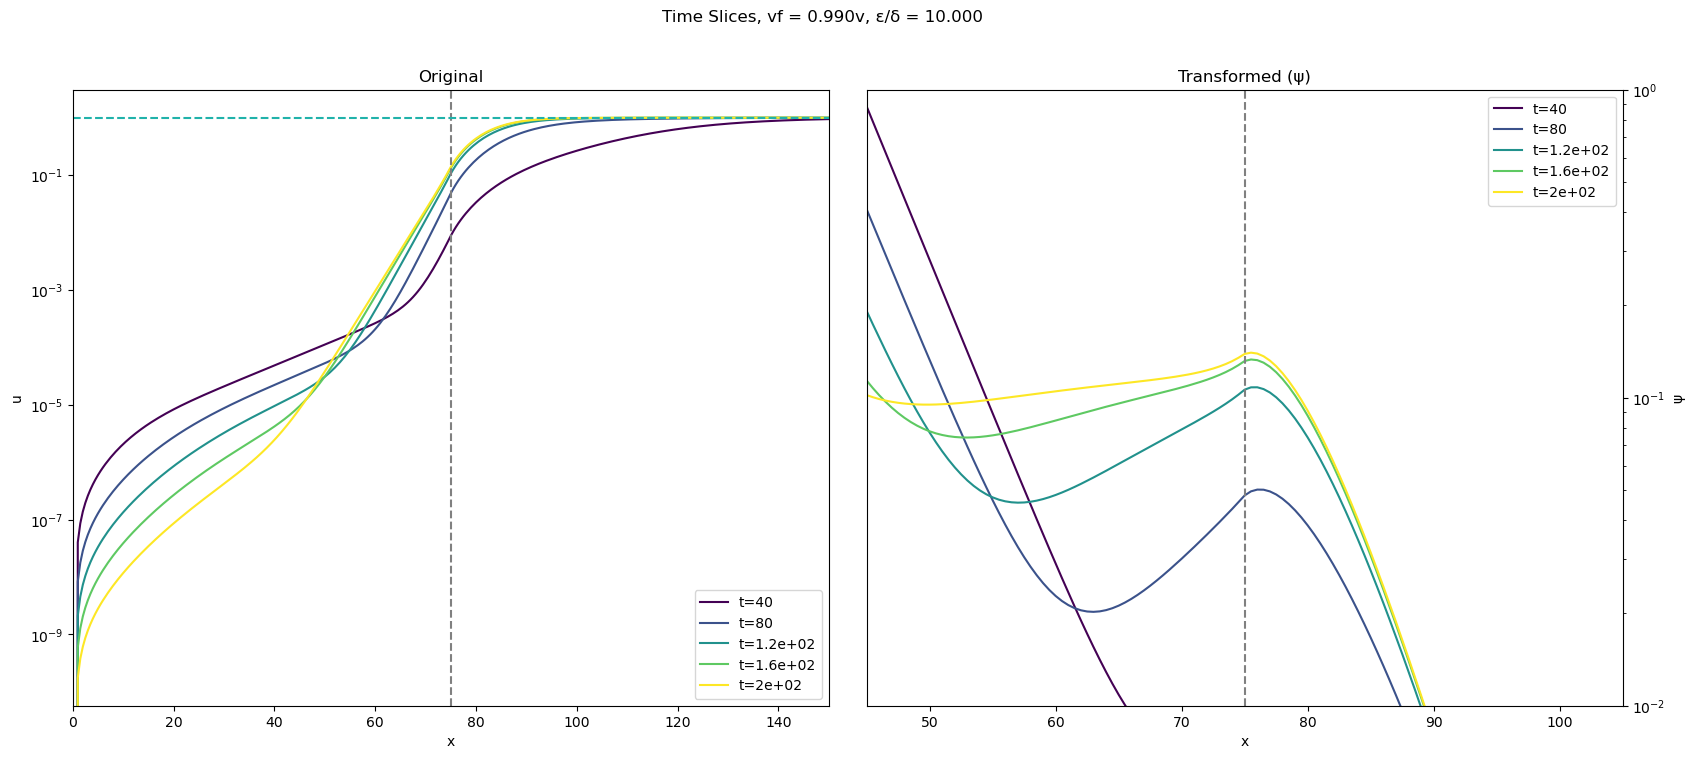

In [554]:
v_over_vf = v/vf
eps_over_delta = wind/coff
plot_time_slices(u, L, dt, N, M, v, D, v_over_vf, eps_over_delta, save_skip=save_skip, psi=True, 
                 log_scale=True, xlim=(0,L/2), psi_xlim = (0.15*L, 0.35*L), psi_ylim=(1e-2,1e0))#, psi_ylim=(1e27,1e47))#, ylim=(1e-1,1e50))#, fractions=[0, 0.6])

#### Gamma solver

In [20]:
# Constants
D = 0.1  # Diffusion coefficient
a = 1.0  # growth rate 
coff = 1 #  strength of u^2 non-linearity 
wind = 1 #  strength of u'^2 non-linearity 
L = 100.0  # Length of the domain
M = 150000 # Number of time steps
dx = 0.01 # Spatial step size
dt = 0.0002 # Time step size
vf = 2 * (D*a)**0.5
v = .9 * vf # wind speed

# Calculate the number of spatial and temporal steps
N = int(L / dx) + 1

# high wind squeezes a Gaussian initialization
# let's try sigmoidal initial conditions
L_center = L / 2  # center point
width = L / 40  # controls the steepness of the sigmoid
N0 = a / coff  # asymptote for the sigmoid
# Set the initial condition using a sigmoid function
u_0 = N0 / (1 + np.exp(- (np.linspace(0, L, N) - L_center) / width))
u_0[-2] = u_0[-1]
u_0[0] = 0
u_0[1] = 0

save_skip = 1 # should use for full simualtion
u = simulate_u(u_0, 'neumann', D, v, a, wind, coff, N, M, dx, dt, debug=False, save_skip=save_skip)

100%|██████████| 149999/149999 [00:17<00:00, 8420.57it/s]


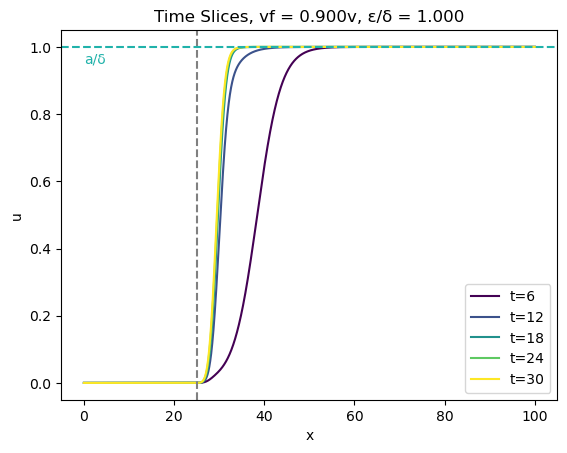

In [21]:
plot_time_slices(u, L, dt, N, M, v, D, v/vf, wind/coff, psi=False, log_scale=False)

In [158]:
def simulate_g(g_0, u, bc, D, v, a, wind, coff, N, M, dx, dt, debug=False, save_skip=1):
    # u_0: np.array of size M
    # debug: boundary conditions
    # save_skip: only save ever save_skip generations for memory reasons
    # Initialize the first time step
    g = g_0.copy()
    
    # Store each time step in a list
    g_list = [g.copy()]
    for k in tqdm(range(M - 1)):
        # Enforce zero boundary condition on the right
        b = N-1
        warnings.simplefilter("error", RuntimeWarning)
        try:
            # Update the interior points
            g_next = g.copy()
            g_next[1:b] = g[1:b] + dt * (
                D * (g[0:b-1] - 2 * g[1:b] + g[2:b+1]) / dx**2 
                + v * (g[2:b+1] - g[1:b]) / dx
                + a * np.heaviside(np.arange(1, b) - N // 4, 0) * g[1:b]
                + wind * g[1:b] * (u[:b-1] - 2 * u[1:b] + u[2:b+1]) / dx**2
                + wind * (g[2:b+1] - g[1:b]) / dx * (u[2:b+1] - u[1:b]) / dx
                - coff * u[1:b] * g[1:b]
            )
            # Apply boundary conditions separately
            if bc == 'neumann':
                # Neumann boundary conditions for the first and last points
                g_next[0] = g[0] + dt * (
                    D * (g[2] - 2 * g[1] + g[0]) / dx**2 
                    + v * (g[2] - g[1]) / dx
                    + wind * g[1] * (u[2] - 2 * u[1] + u[0]) / dx**2
                    + wind * (g[2] - g[1]) / dx * (u[2] - u[1]) / dx
                    - coff * u[1] * g[1]
                )
                g_next[-1] = g[-1] + dt * (
                    D * (g[-3] - 2 * g[-2] + g[-1]) / dx**2 
                    + v * (g[-1] - g[-2]) / dx
                    + a * g[-2]
                    + wind * g[-2] * (u[-3] - 2 * u[-2] + u[-1]) / dx**2
                    + wind * (g[-1] - g[-2]) / dx * (u[-1] - u[-2]) / dx
                    - coff * u[-2] * g[-2]
                )
                #if debug:
                #    print(f"u_next[1]-u_next[0]: {_next[1]-u_next[0]}")
                #    print(f"u_next[-1]-u_next[-2]: {u_next[-1]-u_next[-2]}")

            elif bc == 'dirichlet':
                # Dirichlet boundary conditions for the first and last points
                g_next[0] = 0
                g_next[-1] = 0
            else:
                raise ValueError(f"Use 'neumann' or 'dirichlet'.")              
                
            normalization = np.sum(g_next * u) * dx
            g_next = g_next/normalization
            g = g_next
            
            # Append the updated u_next to the list
            if (k+1) % save_skip == 0: 
                g_list.append(g_next.copy())         

        except RuntimeWarning as e:
            # Print the time of the error
            print(f"RuntimeWarning occurred at time step {k} and time {k*dt}: {e}")
            break
        

    # Convert the list of arrays into a 2D NumPy array
    g_array = np.array(g_list)
    
    return g_array

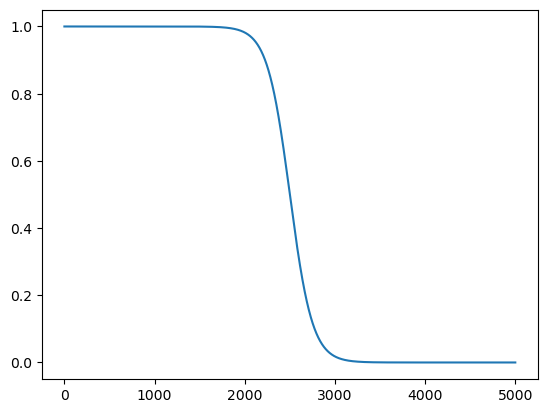

In [159]:
M = 500000
# Set the initial condition
"""
g_0 = N0/(sigma0 * np.sqrt(2 * np.pi)) * np.exp( - (np.linspace(0, L, N) - L // 2)**2 / (2 * sigma0**2))
"""
# some Gaussian initial conditions
sigma0 = L/20 # initial width
# N0 = 1000

# Set the initial condition to reverse sigmoid
L_center = L / 2  # center point
width = L / 40  # controls the steepness of the sigmoid
N0 = a / coff  # asymptote for the sigmoid
# Set the initial condition using a sigmoid function
g_0 = N0 / (1 + np.exp( (np.linspace(0, L, N) - L_center) / width))
g_0[-1] = 0
g_0[-2] = 0
g_0[0] = 1
g_0[1] = 1

plt.plot(g_0)

In [160]:
# set inner product condition on u and g_0
u_sol = u[-1]
integral = np.sum(g_0*u_sol*dx)

g_0 = g_0 / (integral)

save_skip=1000
g = simulate_g(g_0, u_sol, 'neumann', D, v, a, wind, coff, N, M, dx, dt, debug=False, save_skip=save_skip)
#g = simulate_g(g_0, u_sol, 'dirichlet', D, v, a, wind, coff, N, M, dx, dt, debug=False, save_skip=save_skip)

100%|██████████| 499999/499999 [00:57<00:00, 8692.72it/s]


In [41]:
np.sum(g[-1] * u[-1] * dx)

1.0000000000000004

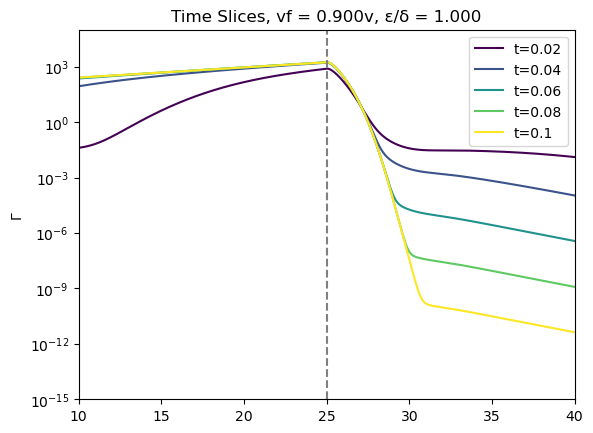

In [44]:
plot_time_slices(g, L, dt, N, M, v, D, v/vf, wind/coff, log_scale=True, 
                 gamma=True, psi=False, ylim=(1e-15,1e5),xlim=(10,40))#, fractions=[0, 0.1, 0.5])

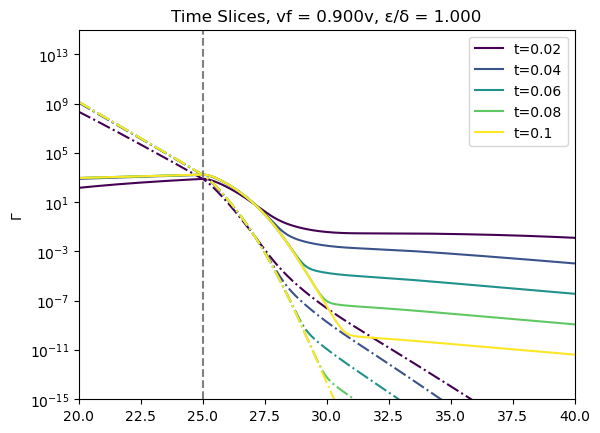

In [46]:
plot_time_slices(g, L, dt, N, M, v, D, v/vf, wind/coff, log_scale=True, 
                 gamma=True, psi=True, ylim=(1e-15,1e15),xlim=(20,40))#, fractions=[0, 0.1, 0.5])

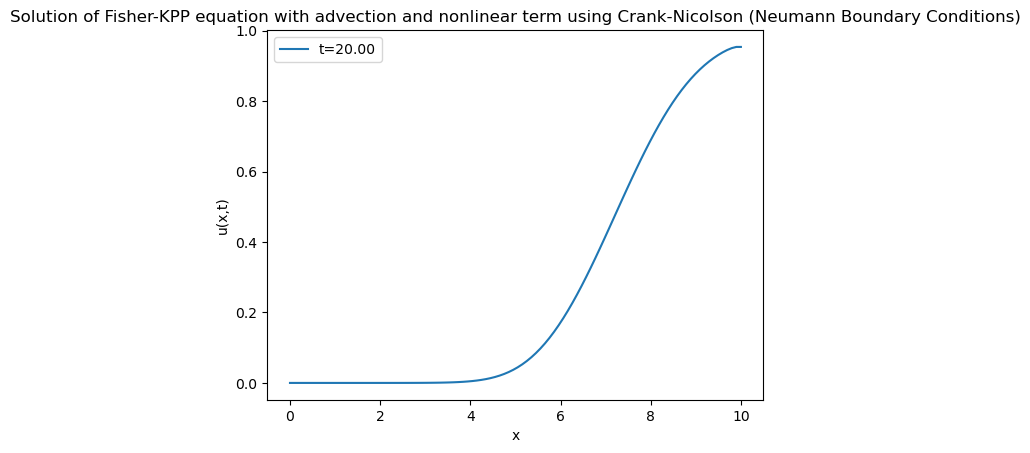

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Parameters
L = 10.0            # Length of the spatial domain
T = 20.0            # Total time
Nx = 100            # Number of spatial points
Nt = 2000           # Number of time steps
D = 0.1             # Diffusion coefficient
r = 1.0             # Reaction rate
vf = 2 * (D * r)**0.5
v = 0.9 * vf        # Advection velocity
boundary_condition = 'neumann'  # Option: 'dirichlet' or 'neumann'
delta = 0.01        # Nonlinearity coefficient

# Discretization
dx = L / (Nx - 1)
dt = T / Nt
x = np.linspace(0, L, Nx)
u = np.zeros(Nx)
u_new = np.zeros_like(u)

# Initial condition: Sigmoidal
k = 10.0            # Steepness of the sigmoid
x0 = L / 2          # Center of the sigmoid
u = 1 / (1 + np.exp(-k * (x - x0)))

# Crank-Nicolson coefficients
alpha = D * dt / (2 * dx**2)
beta = -v * dt / (2 * dx)

# Create tridiagonal matrix for Crank-Nicolson
main_diag = (1 + 2 * alpha) * np.ones(Nx)
off_diag = -alpha * np.ones(Nx - 1)
A = diags([main_diag, off_diag, off_diag], [0, -1, 1], format='csr')

# Time-stepping
for n in range(Nt):
    # Compute the gradient du/dx
    du_dx = np.roll(u, -1) - np.roll(u, 1)
    du_dx /= (2 * dx)

    # Compute the additional nonlinearity term
    nonlinearity = -delta * du_dx**2

    # Right-hand side vector with advection term and additional nonlinearity
    b = u + alpha * (np.roll(u, -1) - 2*u + np.roll(u, 1)) + dt * r * u * (1 - u) + nonlinearity
    b[1:-1] += beta * (u[2:] - u[:-2])

    # Apply boundary conditions
    if boundary_condition == 'dirichlet':
        b[0] = 0.0  # u(0, t) = 0
        b[-1] = 0.0  # u(L, t) = 0
        # Boundary conditions are already handled in the matrix A
    elif boundary_condition == 'neumann':
        # Adjust matrix A and right-hand side vector b for Neumann conditions
        A[0, 0] = 1.0
        A[0, 1] = -1.0
        A[-1, -1] = 1.0
        A[-1, -2] = -1.0
        b[0] = 0.0  # No flux at x = 0
        b[-1] = 0.0  # No flux at x = L

    # Solve the linear system A*u_new = b
    u_new = spsolve(A, b)

    # Update u for the next time step
    u[:] = u_new[:]

# Plot the final result
plt.plot(x, u, label='t={:.2f}'.format(T))
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title(f'Solution of Fisher-KPP equation with advection and nonlinear term using Crank-Nicolson ({boundary_condition.capitalize()} Boundary Conditions)')
plt.legend()
plt.show()